<a href="https://colab.research.google.com/github/gabrieladamasceno/Attacks_5G/blob/main/MLP_Bin%C3%A1rio_Zero_Day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Acessar dataset
drive.mount('/content/gdrive')

# Carregar o dataset
encoded = pd.read_csv("/content/gdrive/MyDrive/Datasets/Attacks/Encoded/Encoded.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [84]:
pip install imbalanced-learn


In [85]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


In [87]:
# Usando shape
num_amostras = encoded.shape[0]
print(f"Número de amostras: {num_amostras}")

# Usando len()
num_amostras_len = len(encoded)
print(f"Número de amostras (usando len): {num_amostras_len}")

Número de amostras: 1215890
Número de amostras (usando len): 1215890


In [88]:
# Exibir os nomes de todas as colunas
colunas = encoded.columns.tolist()  # Converte o Index em uma lista
print("Nomes das colunas:")
for coluna in colunas:
    print(coluna)

Nomes das colunas:
Unnamed: 0
Seq
Dur
RunTime
Mean
Sum
Min
Max
sTos
dTos
sTtl
dTtl
sHops
dHops
TotPkts
SrcPkts
DstPkts
TotBytes
SrcBytes
DstBytes
Offset
sMeanPktSz
dMeanPktSz
Load
SrcLoad
DstLoad
Loss
SrcLoss
DstLoss
pLoss
SrcGap
DstGap
Rate
SrcRate
DstRate
SrcWin
DstWin
sVid
dVid
SrcTCPBase
DstTCPBase
TcpRtt
SynAck
AckDat
Label
Attack Type
Attack Tool
 *        
 *    V   
 *    f   
 e        
 e    f   
 e &      
 e *      
 e d      
 e g      
 e i      
 e r      
 e s      
 eU       
e        
arp
icmp
ipv6-icmp
llc
lldp
sctp
tcp
udp
ACC
CON
ECO
FIN
INT
NRS
REQ
RSP
RST
TST
URP
Shutdown
Start
Status
39
4
52
54
af11
af12
af41
cs0
cs4
cs6
cs7
ef
nan


In [89]:
# Selecionar apenas colunas numéricas
numeric_cols = encoded.select_dtypes(include=['number']).columns

# Aplicar a suavização apenas nas colunas numéricas
for col in numeric_cols:
    encoded[col] = encoded[col].fillna(encoded[col].mean())

In [90]:
# columns with null values

columns_null = []
columns = encoded.columns
for column in columns:
    c = encoded[column].isnull().sum()
    if c != 0:
        print(column, 'has {} null values'.format(c))
        columns_null.append(column)

Features
* Seq: Sequência de pacotes.
* Offset: Deslocamento em bytes.
* sTtl: Time to Live da fonte.
* tcp: Indica se o protocolo TCP está sendo usado.
* AckDat: Dados de reconhecimento.
* RST: Sinalizador de reinício TCP.
* INT: Interrupções no fluxo de dados.
* TcpRtt: Tempo de ida e volta do TCP.
* icmp: Indica se o protocolo ICMP está presente.
* sMeanPktSz: Tamanho médio do pacote da fonte.
* FIN: Sinalizador de finalização de conexão.
* sHops: Número de saltos até o destino.
* Mean: Valor médio de um conjunto de dados.
* dTtl: Time to Live do destino.
* SrcBytes: Bytes enviados da fonte.
* TotBytes: Total de bytes.
* dMeanPktSz: Tamanho médio do pacote do destino.
* Status: Estado da conexão.
* cs0: Parâmetro de controle.
* SrcWin: Janela de origem TCP.
* sTos: Tipo de serviço.
* CON: Conexões.
* REQ: Requisições.
* Loss: Taxa de perda de pacotes.

In [91]:

import pandas as pd

# Selecionar apenas as colunas 'Label' e 'Attack Type'
icmp_flood_samples = encoded[['Label', 'icmp', 'Attack Type']]

icmp_flood_samples

,Label,icmp,Attack Type
0,Benign,1.0,Benign
1,Benign,1.0,Benign
2,Benign,0.0,Benign
3,Benign,0.0,Benign
4,Benign,0.0,Benign
...,...,...,...
1215885,Benign,0.0,Benign
1215886,Benign,0.0,Benign
1215887,Benign,0.0,Benign
1215888,Benign,0.0,Benign


In [92]:
import psutil
import time
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Função para monitorar recursos
def monitor_resource_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    cpu_percent = psutil.cpu_percent(interval=0.1)
    memory_usage_mb = memory_info.rss / (1024 * 1024)
    return cpu_percent, memory_usage_mb

# Callback para monitorar CPU e Memória
class ResourceMonitor(Callback):
    def on_train_begin(self, logs=None):
        self.cpu_usage = []
        self.memory_usage = []
        self.start_time = time.time()
        print("\n[Início do Treinamento]")

    def on_epoch_begin(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        print(f"\n[Época {epoch + 1} - Início] CPU: {cpu:.2f}%, Memória: {mem:.2f} MB")

    def on_epoch_end(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        print(f"[Época {epoch + 1} - Fim] CPU: {cpu:.2f}%, Memória: {mem:.2f} MB")

    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        avg_cpu = np.mean(self.cpu_usage)
        avg_mem = np.mean(self.memory_usage)

        print("\n[Fim do Treinamento]")
        print(f"Tempo total: {total_time:.2f} segundos")
        print(f"Uso médio de CPU: {avg_cpu:.2f}%")
        print(f"Consumo médio de memória: {avg_mem:.2f} MB")

# Instanciar o callback
resource_monitor = ResourceMonitor()

# Parâmetros para early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [93]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from keras.regularizers import l2

# Configuração das features e rótulos
features = [
    'Seq', 'Offset', 'sTtl', 'tcp', 'AckDat', 'RST', 'INT', 'TcpRtt', 'icmp',
    'sMeanPktSz', 'FIN', 'sHops', 'Mean', 'dTtl', 'SrcBytes', 'TotBytes',
    'dMeanPktSz', 'Status', 'cs0', 'SrcWin', 'sTos', 'CON', 'REQ', 'Loss', 'Attack Type'
]

X = encoded[features]
y = encoded['Label']  # Coluna de rótulos

# Divida os dados normalmente
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identifique as amostras ICMPFlood no conjunto de treino
train_zero_day_indices = X_train[X_train['Attack Type'] == 'ICMPFlood'].index

# Remova essas amostras de ICMPFlood do conjunto de treino
X_train_clean = X_train.drop(train_zero_day_indices)
y_train_clean = y_train.drop(train_zero_day_indices)

# Identifique as amostras ICMPFlood no conjunto de teste
test_zero_day_indices = X_test[X_test['Attack Type'] == 'ICMPFlood'].index

# Mantenha as amostras de ICMPFlood no conjunto de teste
X_test_zero_day = X_test.loc[test_zero_day_indices]
y_test_zero_day = y_test.loc[test_zero_day_indices]

# Verificar a distribuição das classes no conjunto de teste
print(f"Zero-day presente no conjunto de teste: {any(test_zero_day_indices.isin(X_test_zero_day.index))} \n")

# Verificar as distribuições
print("Distribuição do conjunto de treino binário:", pd.Series(y_train_clean).value_counts())
print("Distribuição do conjunto de teste binário:", pd.Series(y_test_zero_day).value_counts())

# Remover a coluna 'Attack Type' das features de treino e teste
X_train_clean = X_train_clean.drop(columns=['Attack Type'])
X_test = X_test.drop(columns=['Attack Type'])
X_test_zero_day = X_test_zero_day.drop(columns=['Attack Type'])

Zero-day presente no conjunto de teste: True 

Distribuição do conjunto de treino binário: Label
Malicious    589852
Benign       381943
Name: count, dtype: int64
Distribuição do conjunto de teste binário: Label
Malicious    238
Name: count, dtype: int64


In [94]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd

# Configurar o SMOTE
smote = SMOTE(random_state=42)

# Aplicar SMOTE no conjunto de treinamento
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_clean, y_train_clean)

# Verificar distribuição das classes após o SMOTE
print(f"Distribuição após SMOTE:\n{pd.Series(y_train_balanced).value_counts()}")

# Normalizar os dados após o SMOTE
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)

# Normalizar o conjunto de teste com o mesmo scaler ajustado no treino
X_test_combined = scaler.transform(X_test)
y_test_combined = y_test

Distribuição após SMOTE:
Label
Malicious    589852
Benign       589852
Name: count, dtype: int64


In [95]:
# Verificar a dimensão do teste
print(X_test_combined.shape)
print(y_test_combined.shape)
print(f"Distribuição Teste:\n{pd.Series(y_test_combined).value_counts()}")

(243178, 24)
(243178,)
Distribuição Teste:
Label
Malicious    147384
Benign        95794
Name: count, dtype: int64


In [96]:
from sklearn.preprocessing import LabelEncoder

# Criar o codificador
label_encoder = LabelEncoder()

# Ajustar o codificador aos rótulos de treinamento e teste
y_train_balanced = label_encoder.fit_transform(y_train_balanced)
y_test_combined = label_encoder.transform(y_test_combined)

# Verificar os tipos após a transformação
print(y_train_balanced.dtype)
print(y_test_combined.dtype)

int64
int64


In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Construção do Modelo
model = Sequential()
model.add(Input(shape=(X_train_balanced.shape[1],)))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_test_combined, y_test_combined),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, resource_monitor, reduce_lr]
)


[Início do Treinamento]

[Época 1 - Início] CPU: 0.20%, Memória: 3759.94 MB
Epoch 1/10
36860/36866 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9665 - loss: 0.1914[Época 1 - Fim] CPU: 0.10%, Memória: 3601.58 MB
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 85s 2ms/step - accuracy: 0.9665 - loss: 0.1914 - val_accuracy: 0.9948 - val_loss: 0.0471 - learning_rate: 1.0000e-04

[Época 2 - Início] CPU: 0.20%, Memória: 3601.58 MB
Epoch 2/10
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0425[Época 2 - Fim] CPU: 1.50%, Memória: 3629.77 MB
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - accuracy: 0.9947 - loss: 0.0425 - val_accuracy: 0.9972 - val_loss: 0.0359 - learning_rate: 1.0000e-04

[Época 3 - Início] CPU: 2.10%, Memória: 3629.77 MB
Epoch 3/10
36848/36866 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0314[Época 3 - Fim] CPU: 0.40%, Memória: 3641.92 MB
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - accuracy: 0.9967 - loss: 0.0314 - val_accuracy: 0.9981 - val

In [98]:
# Fazer previsões diretas e arredondar (sem precisar de threshold manual)
y_pred = model.predict(X_test_combined).round()

# Gerar o relatório de classificação
print("\n--- Relatório de Classificação ---")
print(classification_report(y_test_combined, y_pred, target_names=["Benigno", "Malicioso"]))

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 7s 850us/step

--- Relatório de Classificação ---
              precision    recall  f1-score   support

     Benigno       1.00      1.00      1.00     95794
   Malicioso       1.00      1.00      1.00    147384

    accuracy                           1.00    243178
   macro avg       1.00      1.00      1.00    243178
weighted avg       1.00      1.00      1.00    243178



In [99]:
print(f"Tamanho de X_test_zero_day: {X_test_zero_day.shape}")
print(f"Tamanho de y_test_zero_day: {y_test_zero_day.shape}")

Tamanho de X_test_zero_day: (238, 24)
Tamanho de y_test_zero_day: (238,)


In [100]:
# Prever com o modelo para as amostras zero-day

y_pred_zero_day = model.predict(X_test_zero_day)

accuracy_zero_day = (y_pred_zero_day == 1).mean()  # Supondo que '1' é a classe de maligno

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [101]:
print(y_test_zero_day)

765058    Malicious
35586     Malicious
36988     Malicious
766062    Malicious
35511     Malicious
            ...    
35882     Malicious
765081    Malicious
35852     Malicious
36923     Malicious
766407    Malicious
Name: Label, Length: 238, dtype: object


In [102]:
y_test_zero_day = [0. if label == 'Benign' else 1.0 for label in y_test_zero_day]
print(y_test_zero_day)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [103]:
print(y_pred_zero_day)

[[0.52046907]
 [0.        ]
 [0.52046907]
 [0.52046907]
 [0.        ]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.        ]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.        ]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.52046907]
 [0.        ]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.        ]
 [0.52046907]
 [0.        ]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.        ]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.        ]
 [0.52046907]
 [0.        ]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.        ]
 [0.52046907]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.52046907]
 [0.        ]
 [0.        ]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.52046907]
 [0.        ]
 [0.        ]
 [0.52046907]
 [0.        ]
 [0.52046907]
 [0.52

In [104]:
y_pred_zero_day = [0.0 if label == 0. else 1.0 for label in y_pred_zero_day]
print(y_pred_zero_day)

[1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0,

In [105]:
y_pred_zero_day = np.array(y_pred_zero_day, dtype='float32')

In [122]:
# Comparando previsões com os rótulos reais
correct_classifications = (y_pred_zero_day == y_test_zero_day).sum()
total_zero_day_samples = len(y_test_zero_day)

print(f"Zero-day samples classified correctly: {correct_classifications}/{total_zero_day_samples}")
print(f"Accuracy for zero-day samples: {correct_classifications / total_zero_day_samples * 100:.2f}%")

Zero-day samples classified correctly: 173/238
Accuracy for zero-day samples: 72.69%


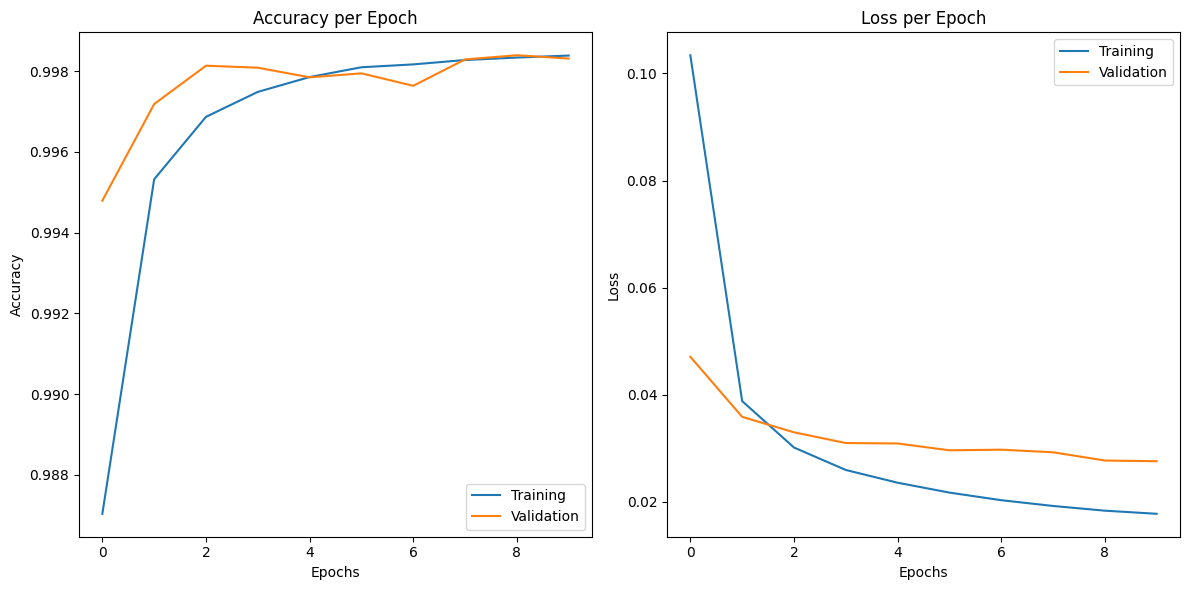

In [118]:
# Accuracy Plot
plt.figure(figsize=(12, 6))

# Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 6s 836us/step


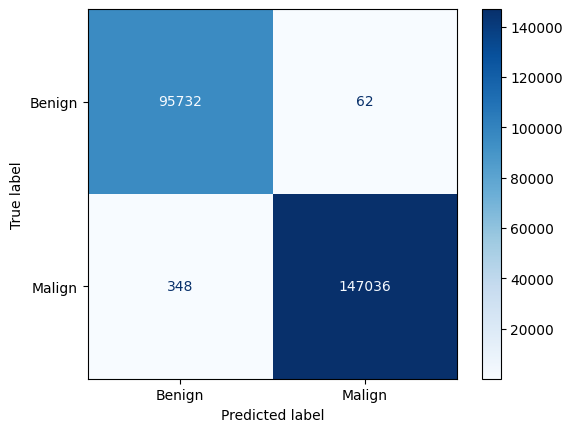

In [120]:
y_test = y_test_combined

#Matrix Confusion

y_pred = model.predict(X_test_combined)
y_pred_classes = (y_pred > 0.5).astype(int)


cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malign"])
disp.plot(cmap='Blues')


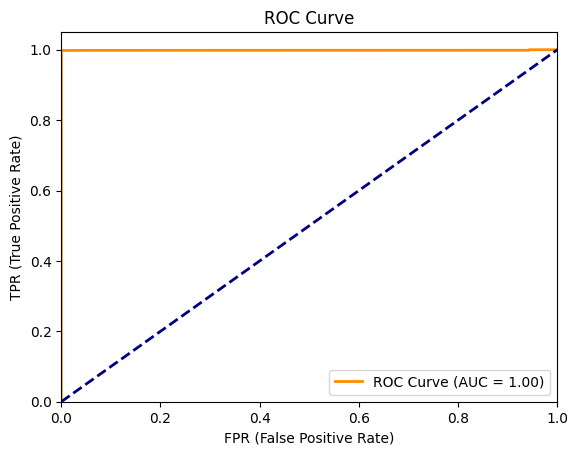

In [121]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_combined, y_pred)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random chance)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()